In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.insert(0,'../')
import NEU_utils

In [2]:
with open('../vgg16_data/fc1_features_std.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
files = data['filename']
fc1 = data['fc1']

In [4]:
labels = [x[:2] for x in files]
y_true = [NEU_utils.label_mapper[x] for x in labels]

In [5]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

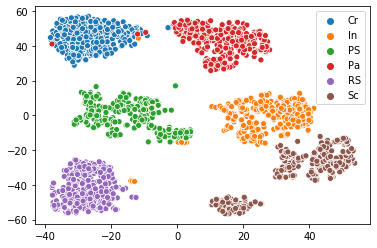

In [6]:
tsne = TSNE(n_components=2, random_state=12213)
x_nw_tsne = tsne.fit_transform(x_nw)
fig, ax = plt.subplots()
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], hue=labels)

Without whitening cluster accuracy is consistently 95.4% (this is shown in figure below as well)
---

In [7]:
for i in range(5):
    kmeans = KMeans(n_clusters=7, init='k-means++', n_init=50, random_state=i)
    kmeans.fit(x_nw)
    labels_unmatched = kmeans.labels_
    y_pred = NEU_utils.file_matcher(labels_unmatched, labels, NEU_utils.label_mapper)
    print(kmeans.random_state)
    print('inertia: {:.2f}'.format(kmeans.inertia_))
    CM = confusion_matrix(y_true, y_pred)
    print(CM)
    print(CM.trace()/CM.sum())

0
inertia: 6639720.28
[[299   0   1   0   0   0]
 [  0 268   2  22   4   4]
 [  6   8 280   3   3   0]
 [  4   7   1 286   1   1]
 [  0   0   1   0 299   0]
 [  0  14   0   1   0 285]]
0.9538888888888889
1
inertia: 6639692.02
[[299   0   1   0   0   0]
 [  0 268   2  22   4   4]
 [  6   7 280   3   4   0]
 [  4   7   1 286   1   1]
 [  0   0   1   0 299   0]
 [  0  13   0   1   0 286]]
0.9544444444444444
2
inertia: 6639682.68
[[299   0   1   0   0   0]
 [  0 269   1  22   4   4]
 [  6   8 280   3   3   0]
 [  4   7   1 286   1   1]
 [  0   0   1   0 299   0]
 [  0  13   0   1   0 286]]
0.955
3
inertia: 6639672.83
[[299   0   1   0   0   0]
 [  0 268   2  22   4   4]
 [  6   7 280   3   4   0]
 [  4   7   1 286   1   1]
 [  0   0   1   0 299   0]
 [  0  13   0   1   0 286]]
0.9544444444444444
4
inertia: 6639720.28
[[299   0   1   0   0   0]
 [  0 268   2  22   4   4]
 [  6   8 280   3   3   0]
 [  4   7   1 286   1   1]
 [  0   0   1   0 299   0]
 [  0  14   0   1   0 285]]
0.9538888888

varying the number of components
===

In [14]:
pca_nw = PCA(whiten=False, svd_solver='full')
pca_w = PCA(whiten=True, svd_solver='full')

pca_nw.fit(fc1)
pca_w.fit(fc1)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='full', tol=0.0, whiten=True)

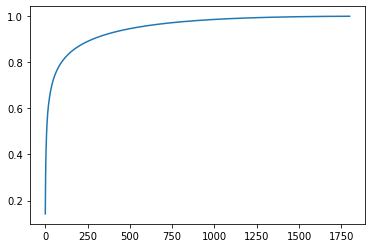

In [15]:
var = pca_w.explained_variance_ratio_.astype(np.float64).cumsum()
plt.plot(var)

In [16]:
nc = [1, 5, 10, 20, 50, 100, 250, 500, 1000, 1800] 
var[np.asarray(nc)-1]

array([0.14199489, 0.4022302 , 0.51699103, 0.61535897, 0.7281695 ,
       0.80349835, 0.89044486, 0.94601959, 0.9861242 , 1.00000012])

In [ ]:
accs_w = []
accs_nw = []
for c in nc:
    print('number of components: {:>4}'.format(c))
    pca_nw = PCA(whiten=False, svd_solver='full', n_components=c)
    pca_w = PCA(whiten=True, svd_solver='full', n_components=c)

    x_nw = pca_nw.fit_transform(fc1)
    x_w = pca_w.fit_transform(fc1)
        
    kmeans_nw = KMeans(n_clusters=7, init='k-means++', n_init=500, random_state=i)
    kmeans_nw.fit(x_nw)
    labels_unmatched_nw = kmeans_nw.labels_
    y_pred_nw  = NEU_utils.file_matcher(labels_unmatched_nw, labels, NEU_utils.label_mapper)
   
    CM_nw = confusion_matrix(y_true, y_pred_nw)
    accs_nw.append(CM_nw.trace()/CM_nw.sum())
    
    kmeans_w = KMeans(n_clusters=7, init='k-means++', n_init=500, random_state=i)
    kmeans_w.fit(x_w)
    labels_unmatched_w = kmeans_w.labels_
    y_pred_w  = NEU_utils.file_matcher(labels_unmatched_w, labels, NEU_utils.label_mapper)
   

    CM_w = confusion_matrix(y_true, y_pred_w)
    accs_w.append(CM_w.trace()/CM_w.sum())


In [9]:
with open('sensitivity_data/pca_num_components.pickle', 'xb') as f:
    pickle.dump({'nc':nc,
                'accs_nw':accs_nw,
                'accs_w':accs_w},
               f)

FileExistsError: [Errno 17] File exists: 'sensitivity_data/pca_num_components.pickle'

NameError: name 'accs_nw' is not defined

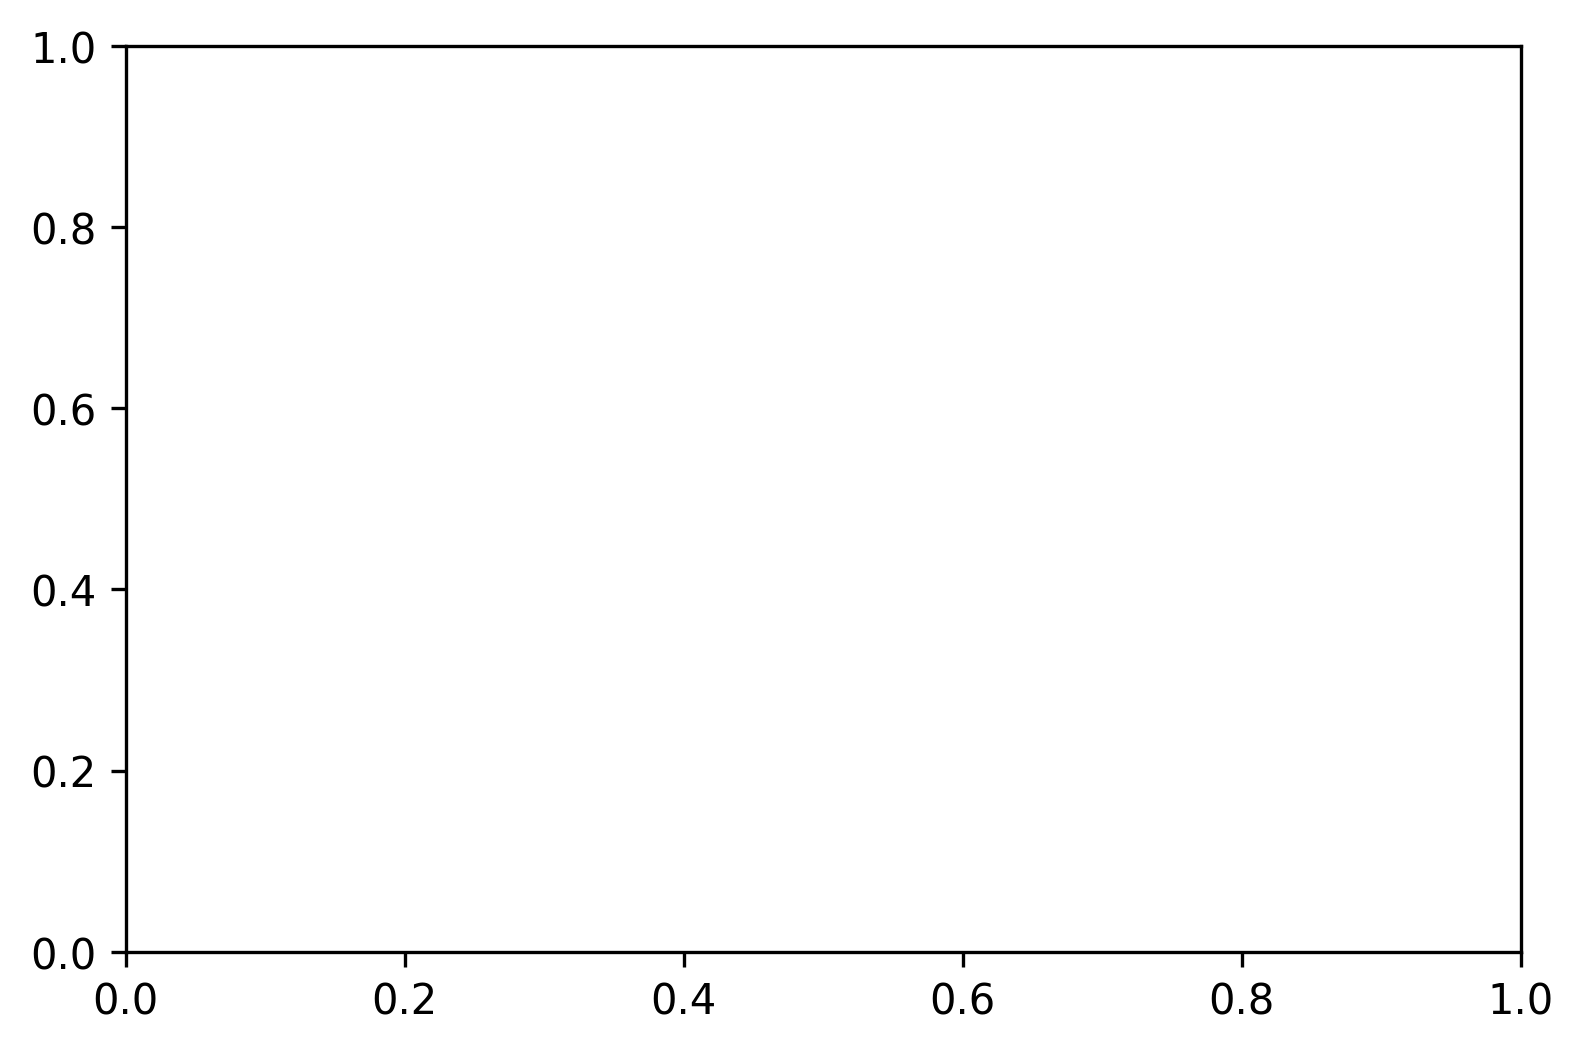

In [17]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.plot(nc, accs_nw, ':ok', label='no whiten')
ax.plot(nc, accs_w, '-.sk', label='whiten')
leg = ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('Clustering accuracy')

In [19]:
pca_w = PCA(whiten=True, svd_solver='full', n_components=100)

x_w = pca_w.fit_transform(fc1)



kmeans_w = KMeans(n_clusters=7, init='k-means++', n_init=500, random_state=4225)
kmeans_w.fit(x_w)
labels_unmatched_w = kmeans_w.labels_
y_pred_w  = NEU_utils.file_matcher(labels_unmatched_w, labels, NEU_utils.label_mapper)


CM_w = confusion_matrix(y_true, y_pred_w)

print(classification_report(y_true, y_pred_w, target_names=NEU_utils.label_list, digits=3))

              precision    recall  f1-score   support

          Cr      0.997     1.000     0.998       300
          In      0.950     0.960     0.955       300
          Pa      1.000     0.993     0.997       300
          PS      0.910     0.777     0.838       300
          RS      1.000     1.000     1.000       300
          Sc      0.781     0.890     0.832       300

    accuracy                          0.937      1800
   macro avg      0.940     0.937     0.937      1800
weighted avg      0.940     0.937     0.937      1800

